In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

directories = [
    "correct_noise_simple_broad",
    "correct_noise_simple_narrow",
    "correct_noise_scattered",
    "correct_noise_complex",
    "correct_noise_drifting",
]

data = []
labels = []

for class_idx, directory in enumerate(directories):
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))

            data_per_directory.append(dynamic_spectra_w_pulse)
            labels.append(class_idx)

    data_per_directory = np.array(data_per_directory)[:100]
    data.append(data_per_directory)

# Concatenate the data and labels
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, random_state=42)

print(data_test.shape)

(100, 1024, 512)


In [49]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output values between 0 and 1 for MNIST
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(decoded.size(0), 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)
        return decoded

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder
autoencoder = Autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        outputs = autoencoder(inputs)
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the autoencoder
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        reconstructed = autoencoder(inputs)
        break  # Only test one batch for simplicity


Epoch [1/10], Loss: 0.0323
Epoch [2/10], Loss: 0.0239
Epoch [3/10], Loss: 0.0180
Epoch [4/10], Loss: 0.0154
Epoch [5/10], Loss: 0.0161
Epoch [6/10], Loss: 0.0188
Epoch [7/10], Loss: 0.0136
Epoch [8/10], Loss: 0.0160
Epoch [9/10], Loss: 0.0158
Epoch [10/10], Loss: 0.0112


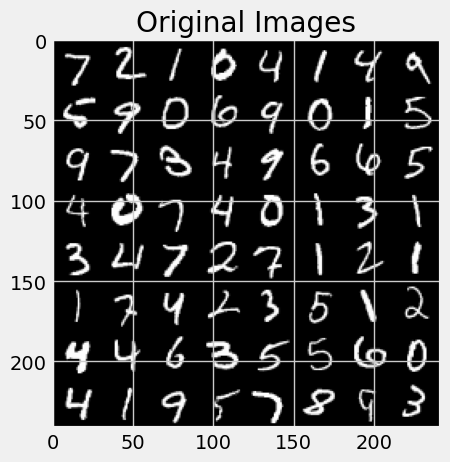

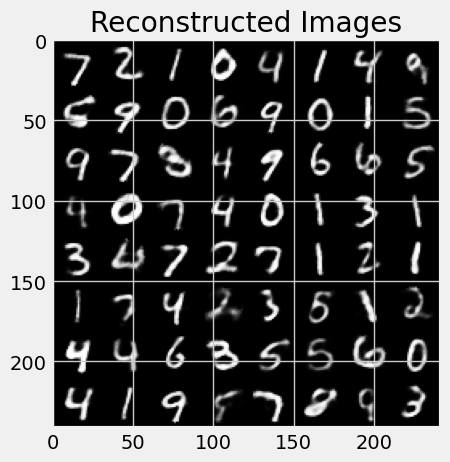

In [47]:
def imshow(img, title):
    img = img.permute(1, 2, 0)  # Change (1, 28, 28) to (28, 28, 1)
    plt.imshow(img.squeeze(), cmap='gray')  # Remove the singleton dimension
    plt.title(title)
    plt.show()

# Plot original images
imshow(torchvision.utils.make_grid(inputs), "Original Images")

# Plot reconstructed images
imshow(torchvision.utils.make_grid(reconstructed), "Reconstructed Images")

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), # 4x512x256
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=3, stride=2, padding=1), # 2#256x128
            nn.ReLU(),
            nn.Flatten(),
            # nn.Linear(65536, 10000) # Takes way too long
            # Add MaxPooling -> hard because how to undo?
        )
        self.decoder = nn.Sequential(
            # nn.Linear(10000, 65536),  # Reverse linear operation
            nn.Unflatten(1, (2, 256, 128)),  # Reverse flatten operation
            nn.ConvTranspose2d(2, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, torch.LongTensor(labels_train))
test_dataset = TensorDataset(data_test_tensor, torch.LongTensor(labels_test))

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data, _ in train_loader:
        inputs = data
        outputs = conv_autoencoder(inputs)
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        inputs = data
        reconstructed = conv_autoencoder(inputs)
        break  # Only test one batch for simplicity


Epoch [1/10], Loss: 0.0062
Epoch [2/10], Loss: 0.0063
Epoch [3/10], Loss: 0.0056
Epoch [4/10], Loss: 0.0041
Epoch [5/10], Loss: 0.0026
Epoch [6/10], Loss: 0.0023
Epoch [7/10], Loss: 0.0025
Epoch [8/10], Loss: 0.0024
Epoch [9/10], Loss: 0.0023
Epoch [10/10], Loss: 0.0024


In [13]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

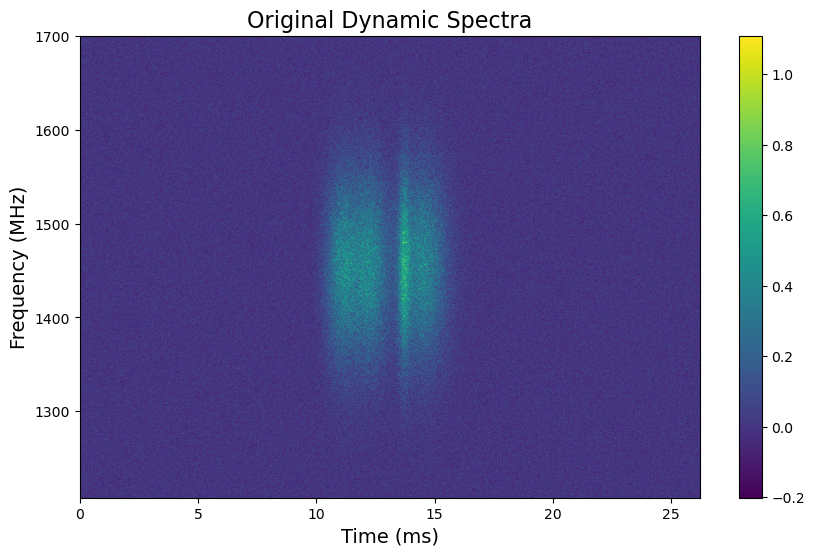

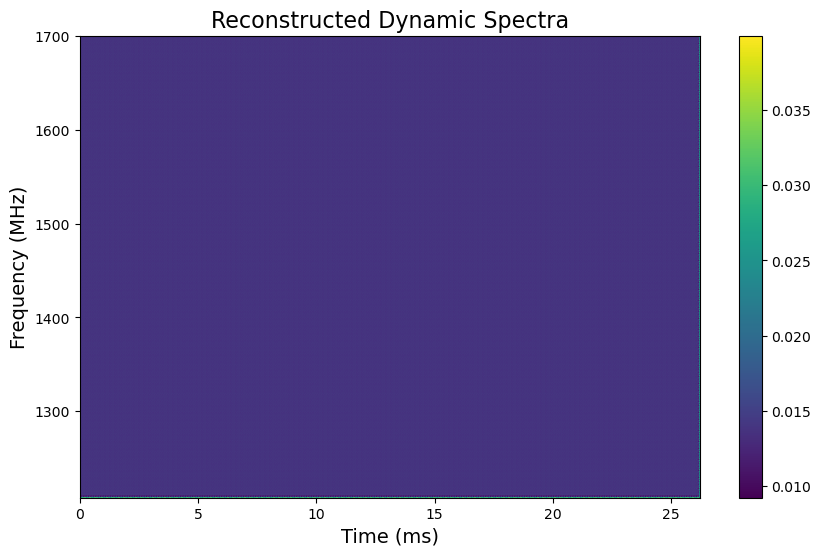

In [12]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        inputs = data
        reconstructed = conv_autoencoder(inputs)[0]
        break  # Only test one batch for simplicity

# Convert tensors to numpy arrays for plotting
original_np = inputs[2].numpy().reshape((1024, 512))
reconstructed_np = reconstructed[2].numpy().reshape((1024, 512))

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")


## Original, Reconstruction & Error plot

[[-1.62869692e-05 -1.05104846e-07 -9.83849168e-06 ... -5.39794564e-06
  -6.15743920e-06 -3.08528543e-05]
 [-1.44140255e-11 -4.95570252e-12 -3.90656889e-18 ... -1.96401629e-20
  -5.18734361e-14 -3.68501684e-18]
 [-1.85682438e-06 -6.24368113e-09 -4.34555113e-06 ... -5.39049506e-06
  -2.34972686e-06 -2.01612711e-05]
 ...
 [-3.91722210e-11 -7.29976080e-11 -2.95952499e-14 ... -1.95568646e-08
  -6.24597305e-07 -8.39427230e-08]
 [-5.45941293e-06 -1.92485750e-05 -1.67172402e-05 ...  2.04443932e-05
  -4.09781933e-05 -4.61935997e-06]
 [-9.40781320e-08 -1.51190907e-05 -4.92900654e-09 ... -3.18442471e-06
  -2.04965472e-05 -2.49110162e-05]]


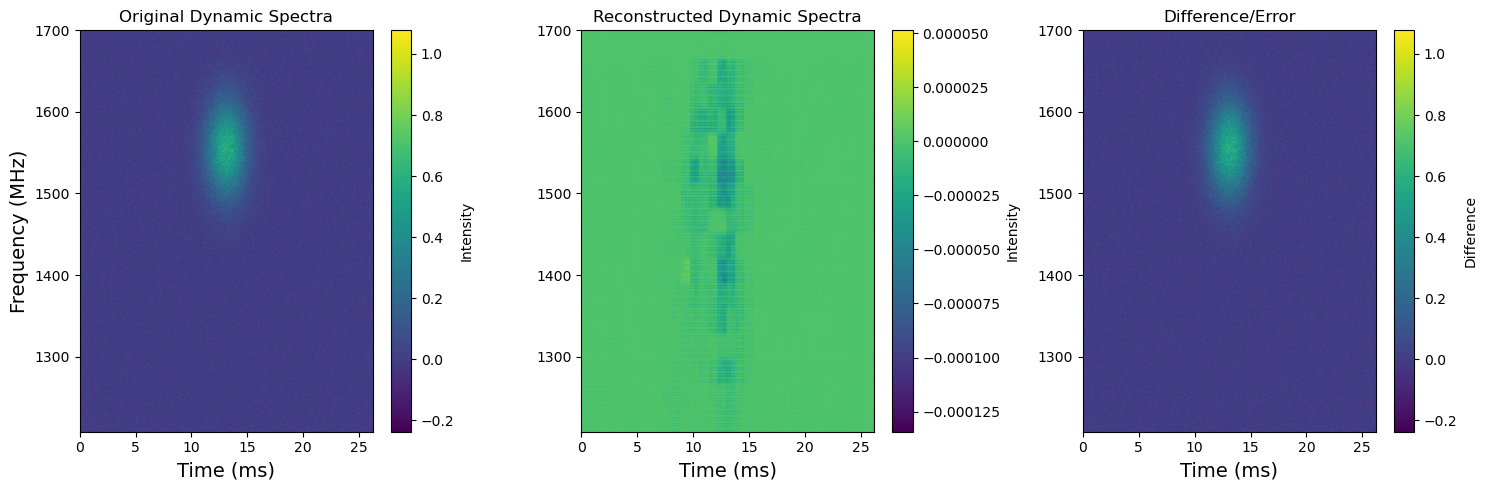

In [219]:
# Convert tensors to numpy arrays for plotting
original_np = inputs[1].numpy().reshape((1024, 512))
reconstructed_np = reconstructed[2].numpy().reshape((1024, 512)) - reconstructed[1].numpy().reshape((1024, 512)) 

# Calculate the difference/error
difference_np = original_np - reconstructed_np

print(reconstructed_np)

# Calculate the time step based on the number of time samples
num_time_samples = original_np.shape[0]
time_step = 0.0000256  # Default time step in seconds

# Calculate the extent based on the number of frequency channels
extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

# Original Dynamic Spectrum
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = axs[0].imshow(original_np.T, aspect="auto", cmap='viridis', origin='lower', extent=extent)
axs[0].set_title("Original Dynamic Spectra")
axs[0].set_xlabel("Time (ms)", size=14)
axs[0].set_ylabel("Frequency (MHz)", size=14)
plt.colorbar(im1, ax=axs[0], label="Intensity")

# Reconstructed Dynamic Spectrum
im2 = axs[1].imshow(reconstructed_np.T, aspect="auto", cmap='viridis', origin='lower', extent=extent)
axs[1].set_title("Reconstructed Dynamic Spectra")
axs[1].set_xlabel("Time (ms)", size=14)
plt.colorbar(im2, ax=axs[1], label="Intensity")

# Difference/Error
im3 = axs[2].imshow(difference_np.T, aspect="auto", cmap='viridis', origin='lower', extent=extent)
axs[2].set_title("Difference/Error")
axs[2].set_xlabel("Time (ms)", size=14)
plt.colorbar(im3, ax=axs[2], label="Difference")

plt.tight_layout()
plt.show()

In [68]:
from torchviz import make_dot

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Visualize the network
x = torch.randn(1, 1, 1024, 512)  # Example input
y = conv_autoencoder(x)

# Use make_dot to create the graph visualization
graph = make_dot(y, params=dict(conv_autoencoder.named_parameters()))

# Save the graph as a PDF file
graph.render("conv_autoencoder_graph")

# Display the graph
graph.view()

'conv_autoencoder_graph.pdf'

## With maxpooling


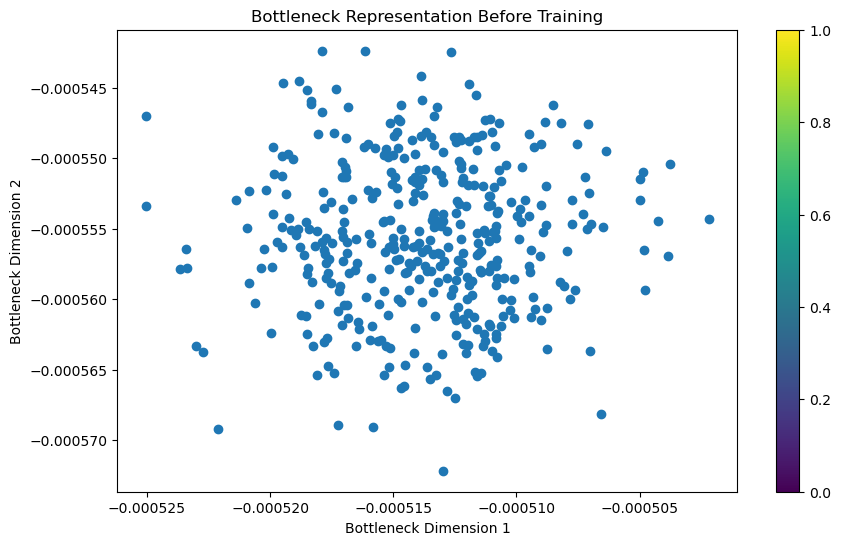

Epoch [1/20], Loss: 0.0057
Epoch [2/20], Loss: 0.0063
Epoch [3/20], Loss: 0.0059
Epoch [4/20], Loss: 0.0059
Epoch [5/20], Loss: 0.0066
Epoch [6/20], Loss: 0.0058
Epoch [7/20], Loss: 0.0053
Epoch [8/20], Loss: 0.0066
Epoch [9/20], Loss: 0.0063
Epoch [10/20], Loss: 0.0063
Epoch [11/20], Loss: 0.0064
Epoch [12/20], Loss: 0.0061
Epoch [13/20], Loss: 0.0059
Epoch [14/20], Loss: 0.0061
Epoch [15/20], Loss: 0.0057
Epoch [16/20], Loss: 0.0064
Epoch [17/20], Loss: 0.0061
Epoch [18/20], Loss: 0.0057
Epoch [19/20], Loss: 0.0066
Epoch [20/20], Loss: 0.0054


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  # 8x512x256
            nn.LeakyReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1),  # 8x256x128
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # 16x128x64
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),  # 16x64x32
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),  # 16x32x16
            nn.LeakyReLU(),
            nn.Flatten(),
            # nn.Linear(8192, 20),
            # nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            # nn.Linear(20, 8192),  # Reverse linear operation
            nn.Unflatten(1, (16, 32, 16)),  # Reverse flatten operation
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2, output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2, output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Now returns both decoded and encoded

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Get the bottleneck representation before training
conv_autoencoder.eval()
with torch.no_grad():
    encoded_representation = conv_autoencoder(data_train_tensor)[1]  # Take the second output (encoded)

# Plot the bottleneck representation
plt.figure(figsize=(10, 6))
plt.scatter(encoded_representation[:, 0], encoded_representation[:, 1])
plt.title('Bottleneck Representation Before Training')
plt.xlabel('Bottleneck Dimension 1')
plt.ylabel('Bottleneck Dimension 2')
plt.colorbar()
plt.show()

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, torch.LongTensor(labels_train))
test_dataset = TensorDataset(data_test_tensor, torch.LongTensor(labels_test))

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer with weight decay
weight_decay = 1e-5  # Adjust as needed
loss_fn = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.001, weight_decay=weight_decay)

# Training the autoencoder
num_epochs = 20  # Increased the number of epochs
for epoch in range(num_epochs):
    for data, _ in train_loader:
        inputs = data
        outputs, _ = conv_autoencoder(inputs)  # Updated to get both decoded and encoded
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# Testing the autoencoder
# conv_autoencoder.eval()
# test_loss = 0.0  # Initialize test loss

# with torch.no_grad():
#     for data, _ in test_loader:
#         inputs = data
#         outputs = conv_autoencoder(inputs)
        
#         # Compute the test loss for the current batch
#         batch_loss = loss_fn(outputs, inputs).item()
#         test_loss += batch_loss

#         # Print the test loss for the current batch
#         print(f'Test Loss (Batch): {batch_loss:.4f}')

# # Calculate and print the average test loss
# average_test_loss = test_loss / len(test_loader.dataset)
# print(f'Average Test Loss: {average_test_loss:.4f}')


torch.Size([100, 8192])


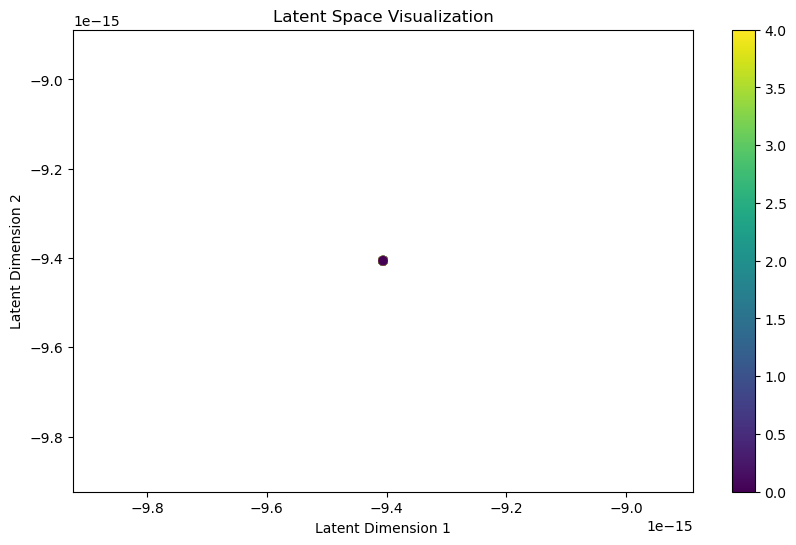

In [9]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    latent_activations = []  # To store latent space activations
    for data, _ in test_loader:
        inputs = data
        encoded = conv_autoencoder(inputs)[1]
        latent_activations.append(encoded)


# Concatenate all activations
latent_activations = torch.cat(latent_activations, dim=0)

print(latent_activations.shape)

# Visualize the latent space
plt.figure(figsize=(10, 6))
plt.scatter(latent_activations[:, 0], latent_activations[:, 1], c=labels_test, cmap='viridis')
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar()
plt.show()

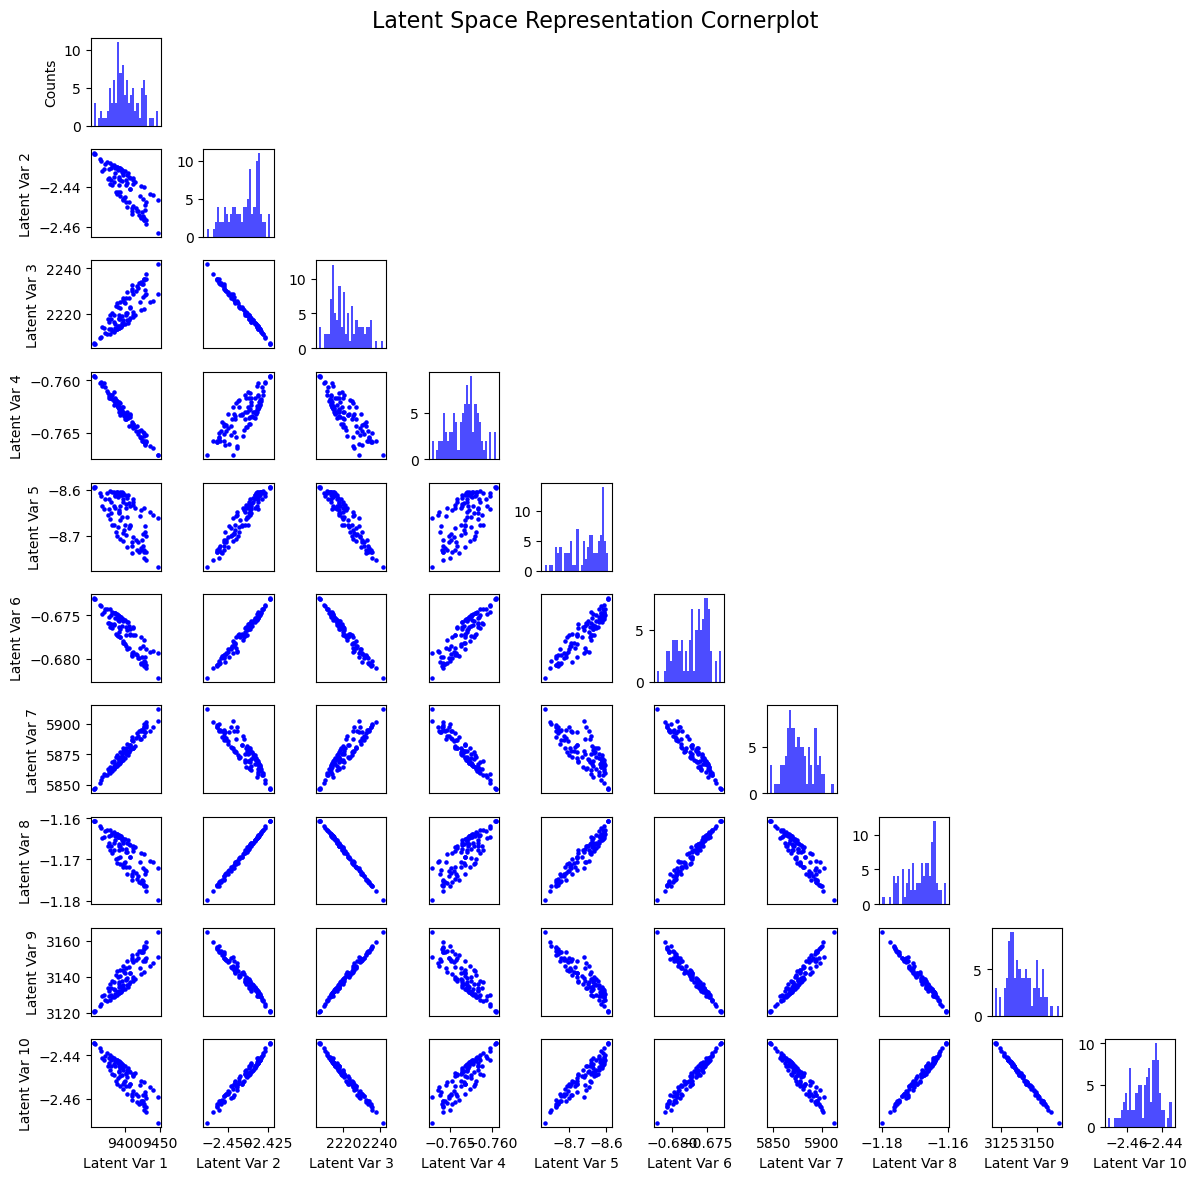

In [197]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Get the number of dimensions in the latent space
num_dimensions = 10

# Create labels for each dimension
labels = [f"Latent Var {i + 1}" for i in range(num_dimensions)]

# Create a square grid of subplots
fig, axes = plt.subplots(num_dimensions, num_dimensions, figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot histograms on the diagonal
for i in range(num_dimensions):
    axes[i, i].hist(latent_activations[:, i], bins=30, color='blue', alpha=0.7)
    if i == 0:
        axes[i, i].set_ylabel('Counts')
    if i == num_dimensions - 1:
        axes[i, i].set_xlabel(labels[i])
        axes[i, i].tick_params(axis='x', bottom=True, top=False)
    else:
        axes[i, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Plot scatter plots under the diagonal
for i in range(num_dimensions):
    for j in range(i + 1, num_dimensions):
        axes[j, i].scatter(latent_activations[:, i], latent_activations[:, j], s=5, color='blue')
        axes[i, j].set_axis_off()
        if i == 0:
            axes[j, i].set_ylabel(labels[j])
            axes[j, i].tick_params(axis='y', left=True, right=False)
        else:
            axes[j, i].tick_params(axis='y', left=False, right=False, labelleft=False)

        # Adjust y-axis labels and ticks
        if j == num_dimensions - 1:
            axes[j, i].set_xlabel(labels[i])
            axes[j, i].tick_params(axis='x', bottom=True, top=False)
        else:
            axes[j, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Put a title 
fig.suptitle('Latent Space Representation Cornerplot', fontsize=16)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



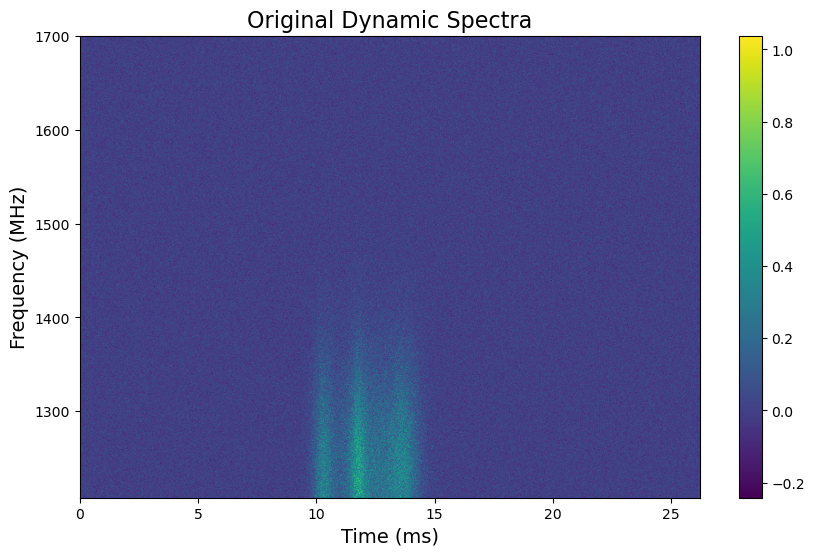

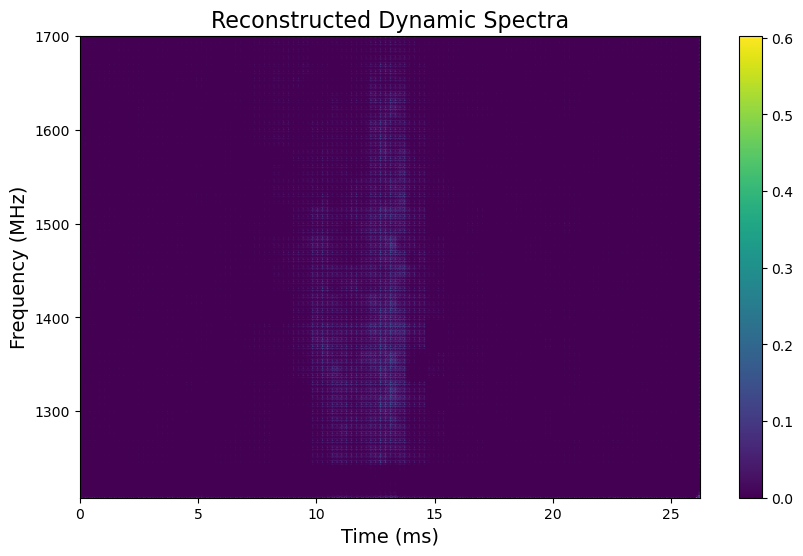

In [213]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    for data, _ in train_loader:
        inputs = data
        reconstructed = conv_autoencoder(inputs)[0]
        break  # Only test one batch for simplicity

# Convert tensors to numpy arrays for plotting
original_np = inputs[0].numpy().reshape((1024, 512))
reconstructed_np = reconstructed[0].numpy().reshape((1024, 512))

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

In [214]:
print("data_train_tensor shape:", data_train_tensor.shape)
print("data_train shape:", data_train.shape)

data_train_tensor shape: torch.Size([400, 1, 1024, 512])
data_train shape: (400, 1024, 512)


## Only a single example

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 16x512x256 (no compression)
            nn.ReLU(),
            # nn.Flatten(),  # Flatten the output
            # nn.Linear(16 * 1024 * 512, 100)  # Projection to 10 latent variables
        )

        self.decoder = nn.Sequential(
            # nn.Linear(100, 16 * 1024 * 512),  # Reverse projection
            # nn.Unflatten(1, (16, 1024, 512)),  # Unflatten to original shape
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # print("Shape after encoder:", encoded.shape)  # Print shape after encoder
        decoded = self.decoder(encoded)
        # print("Shape after decoder:", decoded.shape)  # Print shape after decoder
        return decoded, encoded

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Get a single example for training and testing
single_example = data_train_tensor[0:1]

# Define the loss function and optimizer with weight decay
weight_decay = 1e-5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.001) # No weight decay to start

# Training the autoencoder on a single example
num_epochs = 250
losses = []  # To store the loss values

for epoch in range(num_epochs):
    outputs, _ = conv_autoencoder(single_example)
    loss = loss_fn(outputs, single_example)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())  # Collect the loss value

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss vs training epoch
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss vs Epoch Good Reconstruction')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()


# Reconstruct the single example
with torch.no_grad():
    reconstructed_example, _ = conv_autoencoder(single_example)

# Convert tensors to numpy arrays for plotting
original_np = single_example[0].numpy().reshape((1024, 512))
reconstructed_np = reconstructed_example[0].numpy().reshape((1024, 512))

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

Epoch [1/250], Loss: 0.7213
Epoch [11/250], Loss: 0.4282
Epoch [21/250], Loss: 0.2207
Epoch [31/250], Loss: 0.0908
Epoch [41/250], Loss: 0.0260
Epoch [51/250], Loss: 0.0062
Epoch [61/250], Loss: 0.0039
Epoch [71/250], Loss: 0.0038
Epoch [81/250], Loss: 0.0038
Epoch [91/250], Loss: 0.0038
Epoch [101/250], Loss: 0.0038
Epoch [111/250], Loss: 0.0038
Epoch [121/250], Loss: 0.0038
Epoch [131/250], Loss: 0.0038
Epoch [141/250], Loss: 0.0038
Epoch [151/250], Loss: 0.0038
Epoch [161/250], Loss: 0.0038
Epoch [171/250], Loss: 0.0037
Epoch [181/250], Loss: 0.0037
Epoch [191/250], Loss: 0.0037
Epoch [201/250], Loss: 0.0037
